<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Causal Inference In Statistics - A Primer</h1>
        <h1>2.5 Model Testing and Causal Search</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
    <div style="float: right; margin-right:10px;"> <p><a href="https://amzn.to/3gsFlkO" target=_blank><img src='data/causality.jpeg' width='100px'>
        <!--Amazon Affiliate Link--></a></p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import statsmodels.formula.api as smf

from CausalModel import CausalModel

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

watermark  2.0.2
pandas     1.0.1
matplotlib 3.1.3
json       2.0.9
numpy      1.18.1
autopep8   1.5
Sun Oct 11 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 1d212c7c9c6ff61ce3cfdb5a44a84d012db7b214


Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Model Testing and Causal Search

In [4]:
G = CausalModel()
G.add_causation('X1', 'X2')
G.add_causation('X1', 'X3')
G.add_causation('X3', 'X4')
G.add_causation('X2', 'X4')
G.add_causation('X4', 'X5')

G.pos = {'X1':(0, 2), 'X3':(-1, 1), 'X2': (1, 1), 'X4':(0, 0), 'X5':(0, -1)}

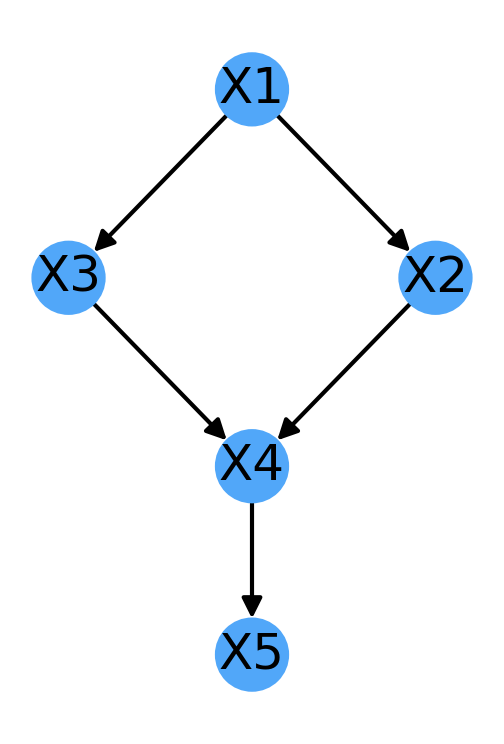

In [5]:
fig, ax = plt.subplots(1, figsize=(2.2, 3))
G.plot()
fig.tight_layout()

In [6]:
G.save_model('dags/Causality.Fig.1.2.dot')

This model has just one v_structure, namely the collider at X4

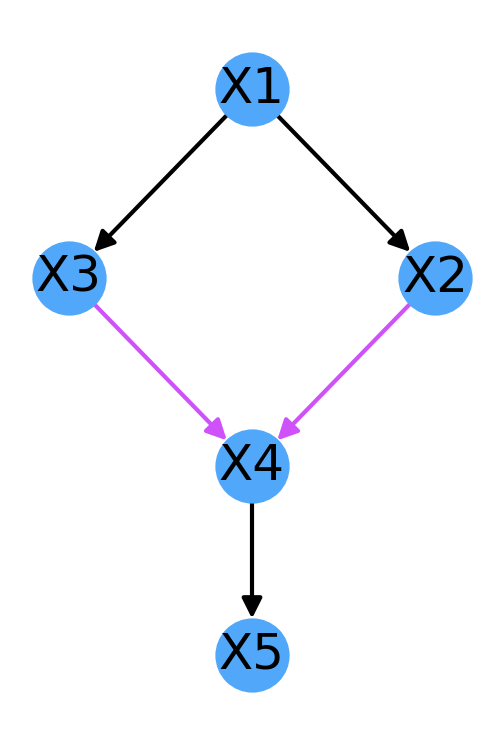

In [7]:
fig, ax_lst = plt.subplots(1, figsize=(2.2, 3))
ax_lst = np.array(ax_lst).flatten()

structs = G.v_structures()

for i, path in enumerate(structs):
    G.plot_path(path, ax=ax_lst[i], edges=True, lw=1)

ax_lst[-1].axis('off')
fig.tight_layout()

But it has 3 models in it's equivalence class

In [8]:
equivalent = G.equivalence_class()

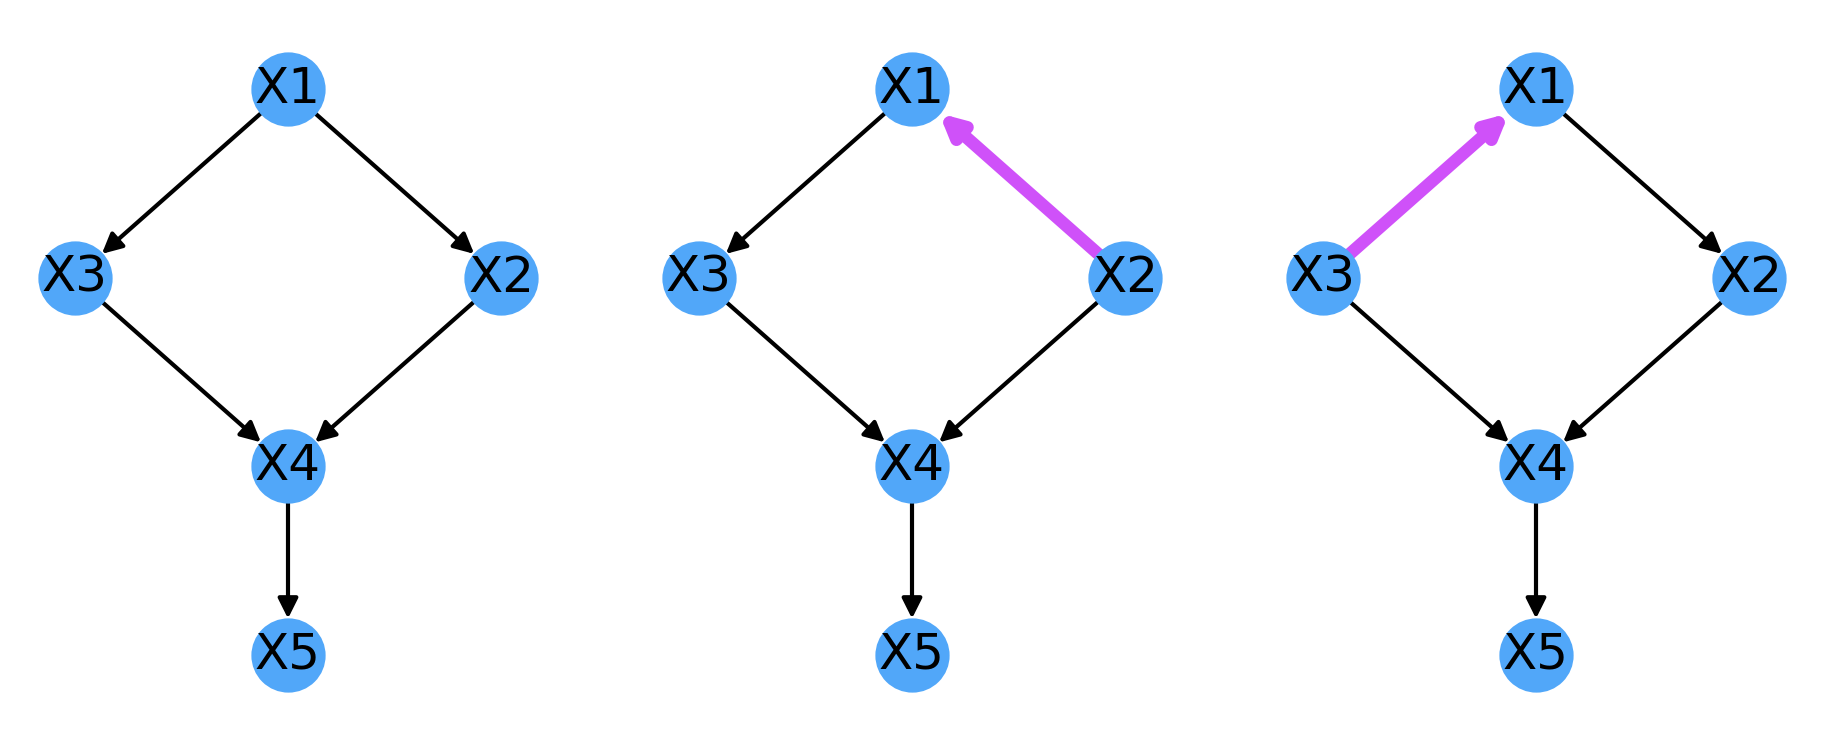

In [9]:
fig, ax_lst = plt.subplots(1, 3, figsize=(6.6, 3))
ax_lst = np.array(ax_lst).flatten()

pos = 0

for graph, edge in equivalent:
    graph.plot_path(edge, ax=ax_lst[pos])
    pos += 1

fig.tight_layout()

One way to verify that these 3 graphs are equivalent is to check their basis set:

In [10]:
for graph, edges in equivalent:
    pprint(graph.basis_set())
    print()

['X2 _||_ X3 | X1',
 'X3 _||_ X2 | X1',
 'X4 _||_ X1 | X2, X3',
 'X5 _||_ X1, X2, X3 | X4']

['X3 _||_ X2 | X1', 'X4 _||_ X1 | X2, X3', 'X5 _||_ X1, X2, X3 | X4']

['X2 _||_ X3 | X1', 'X4 _||_ X1 | X2, X3', 'X5 _||_ X1, X2, X3 | X4']



As we can see, they are exactly the same if we recall that "X3 _||_ X2 | X1" is equivalent to 'X2 _||_ X3 | X1 '

Now we simulate this model to check these equations:

In [11]:
N = 100000
df = pd.DataFrame({'X1': np.random.normal(0, 1, N)})
df['X2'] = df['X1'] + np.random.normal(0, .1, N)
df['X3'] = df['X1'] + np.random.normal(0, .1, N)
df['X4'] = np.sqrt(0.5)*df['X3'] + np.sqrt(0.5)*df['X2'] + np.random.normal(0, .1, N)
df['X5'] = df['X4'] + np.random.normal(0, .1, N)

We will focus on the X5 equation above:

In [12]:
formula = 'X5 ~ 1 + X3 + X1 + X2 + X4'

Which we can fit

In [13]:
model = smf.ols(formula, df)
results = model.fit()

In [14]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     X5   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 5.092e+06
Date:                Sun, 11 Oct 2020   Prob (F-statistic):               0.00
Time:                        12:43:24   Log-Likelihood:                 88491.
No. Observations:              100000   AIC:                        -1.770e+05
Df Residuals:                   99995   BIC:                        -1.769e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0005      0.000     -1.428      0.153      -0.001       0.000
X3             0.0014      0.004      0.357      0.721      -0.006       0.009
X1            -0.0019      0.004     -0.420      0.675      -0.011       0.007
X2            -0.0012      0.004     -0.320      0.749      -0.009       0.006
X4             1.0013      0.003    315.707      0.000       0.995       1.008
==============================================================================
Omnibus:                        1.859   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.395   Jarque-Bera (JB):                1.849
Skew:                          -0.008   Prob(JB):                        0.397
Kurtosis:                       3.013   Cond. No.                         42.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

And verify that the coefficients for X1, X2 and X3 are effectively zero, as expected

In [15]:
def plot_coefficients(results):
    
    summary = results.conf_int().copy()
    summary = pd.concat([summary, results.params], axis=1)
    summary.columns = ['min', 'max', 'value']
    
    independent = results.model.endog_names
    
    fig, ax = plt.subplots(1)
    ax.axvline(x=0, c='darkgray', linestyle=':', linewidth=2)
    ax.hlines(y=np.arange(summary.shape[0]), xmin=summary['min'], xmax=summary['max'], lw=2, color=colors[1])
    ax.vlines(ymin=np.arange(summary.shape[0])-.2, ymax=np.arange(summary.shape[0])+.2, x=summary['value'], lw=2, color=colors[1])
    ax.set_yticks(np.arange(summary.shape[0]))
    ax.set_yticklabels([r'$r_{%s,%s}$' % (independent, node_j) for node_j in summary.index])
    ax.set_xlabel('Coeffient estimate')
    ax.set_ylabel('Variable Pair Coefficient')
    ax.grid(linewidth=.5)

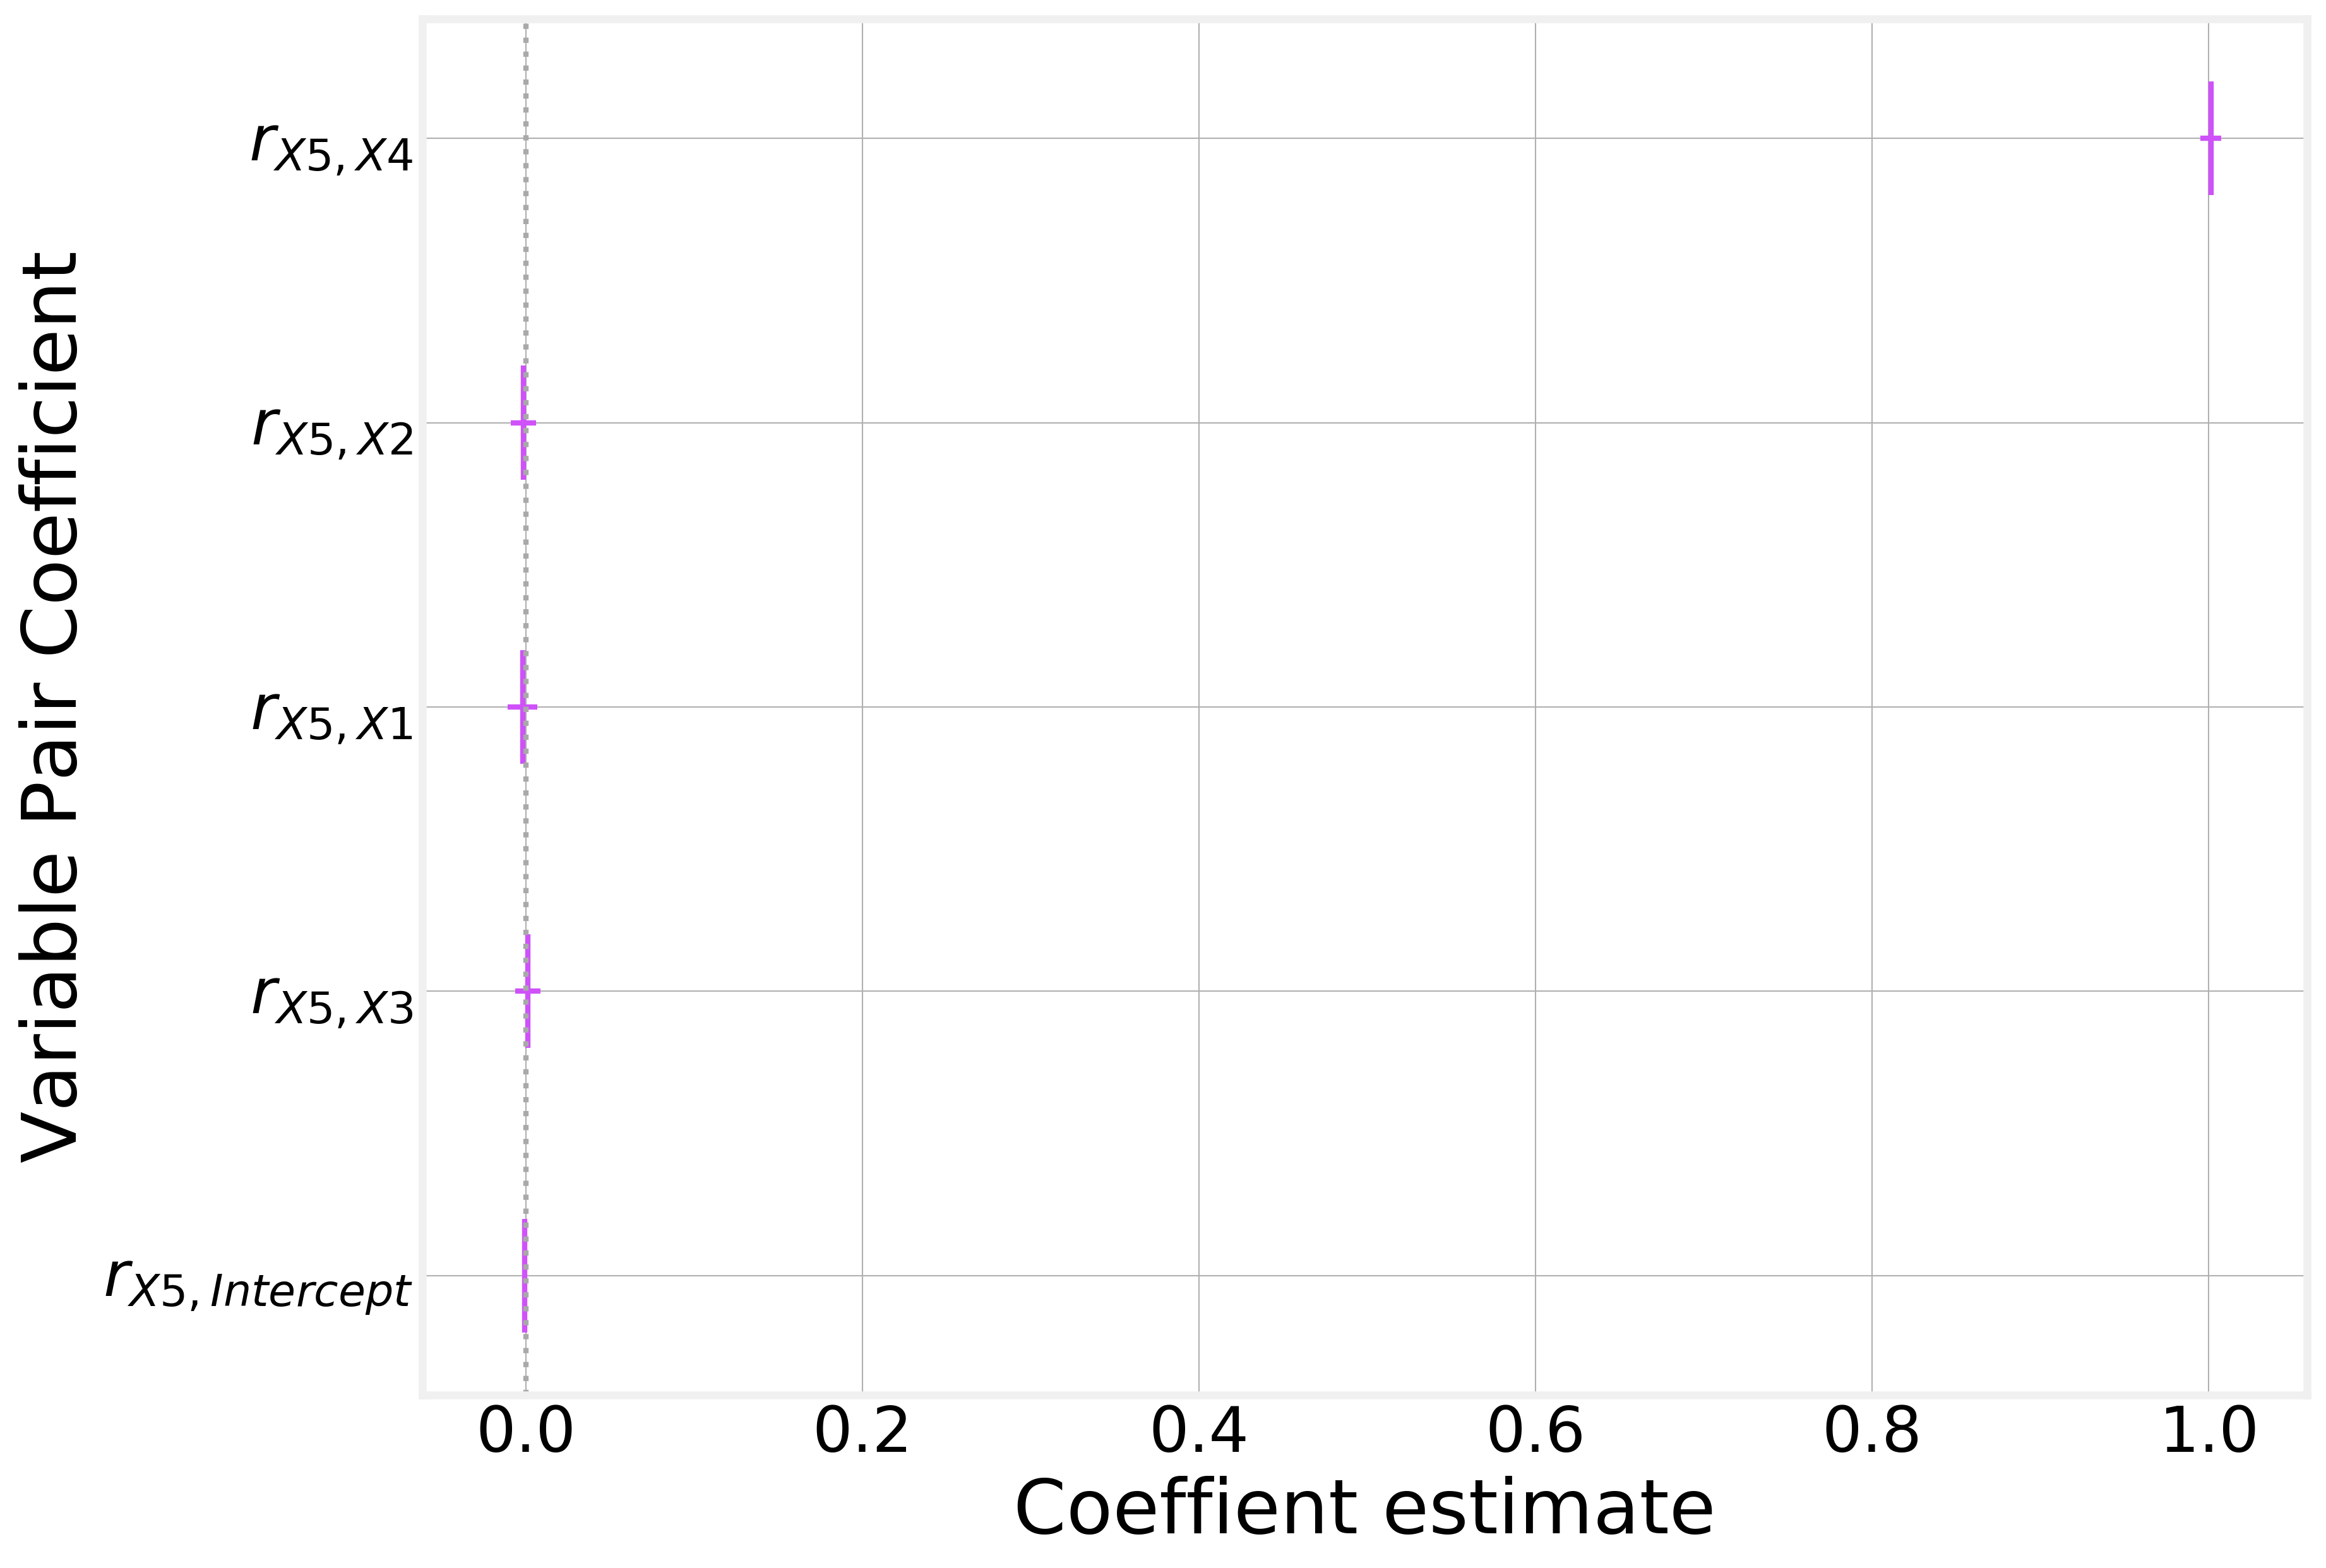

In [16]:
plot_coefficients(results)

Now let us consider a more 

In [17]:
fig29 = CausalModel()
fig29.load_model('dags/Primer.Fig.2.9.dot')

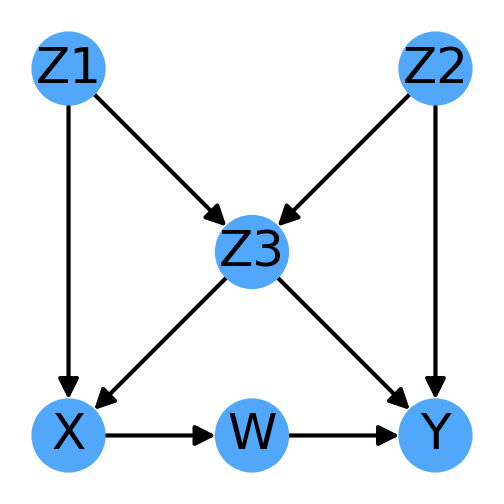

In [18]:
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
fig29.plot(ax=ax)

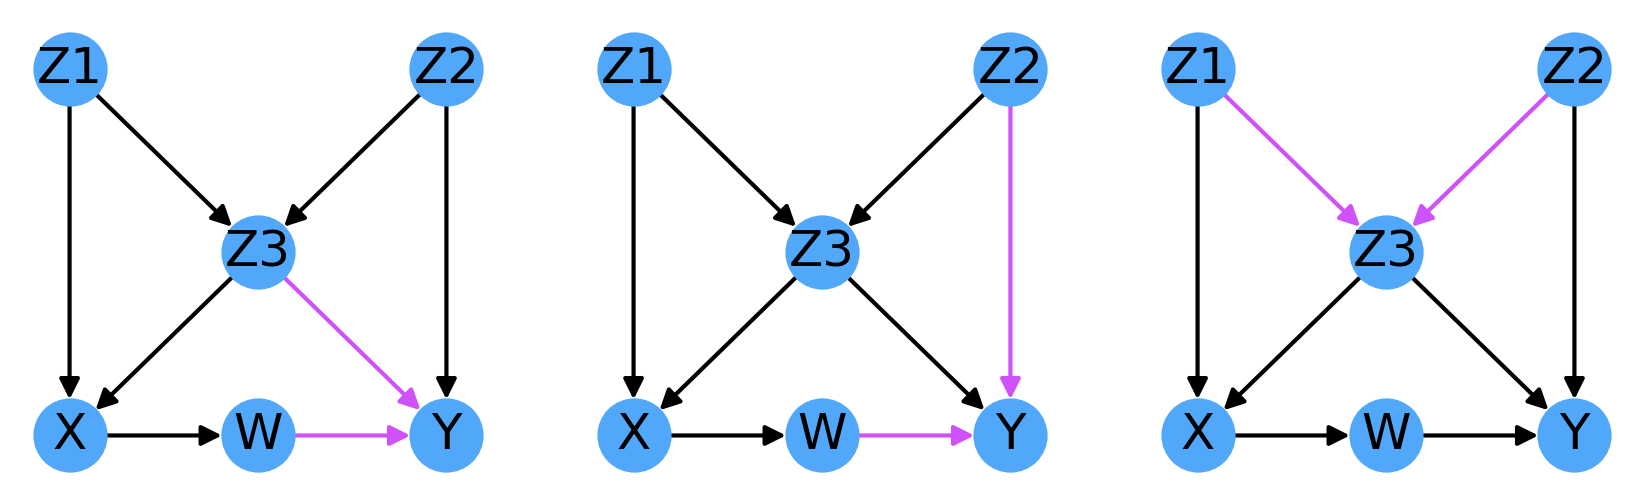

In [19]:
fig, ax_lst = plt.subplots(1, 3, figsize=(6, 2.2))
ax_lst = np.array(ax_lst).flatten()

structs = fig29.v_structures()

for i, path in enumerate(structs):
    fig29.plot_path(path, ax=ax_lst[i], edges=True, lw=1)

ax_lst[-1].axis('off')
fig.tight_layout()

In [20]:
fig29.equivalence_class()

[[<CausalModel.CausalModel at 0x7f9386aa4630>, []]]

In [21]:
fig29.basis_set()

['W _||_ Z1, Z2, Z3 | X',
 'X _||_ Z2 | Z1, Z3',
 'Y _||_ X, Z1 | W, Z2, Z3',
 'Z1 _||_ Z2',
 'Z2 _||_ Z1']

In [22]:
formula = 'Y ~ 1 + X + Z1 + W + Z2 + Z3'

In [23]:
N = 100000
df = pd.DataFrame({'Z1': np.random.normal(0, 1, N), 'Z2': np.random.normal(0, 1, N),})
df['Z3'] = df['Z1'] + df['Z2'] + np.random.normal(0, .1, N)
df['X'] = df['Z1'] + df['Z3'] + np.random.normal(0, .1, N)
df['W'] = df['X'] + np.random.normal(0, .1, N)
df['Y'] = df['W'] + df['Z3'] + df['Z2'] + np.random.normal(0, .1, N)

In [24]:
results = smf.ols(formula, df).fit()

In [25]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.586e+07
Date:                Sun, 11 Oct 2020   Prob (F-statistic):               0.00
Time:                        12:43:30   Log-Likelihood:                 88153.
No. Observations:              100000   AIC:                        -1.763e+05
Df Residuals:                   99994   BIC:                        -1.762e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0003      0.000      1.010      0.312      -0.000       0.001
X             -0.0004      0.004     -0.089      0.929      -0.009       0.008
Z1            -0.0065      0.004     -1.445      0.149      -0.015       0.002
W              1.0038      0.003    316.138      0.000       0.998       1.010
Z2             0.9971      0.003    313.108      0.000       0.991       1.003
Z3             0.9993      0.004    222.321      0.000       0.990       1.008
==============================================================================
Omnibus:                        1.721   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.423   Jarque-Bera (JB):                1.713
Skew:                          -0.010   Prob(JB):                        0.425
Kurtosis:                       3.006   Cond. No.                         68.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

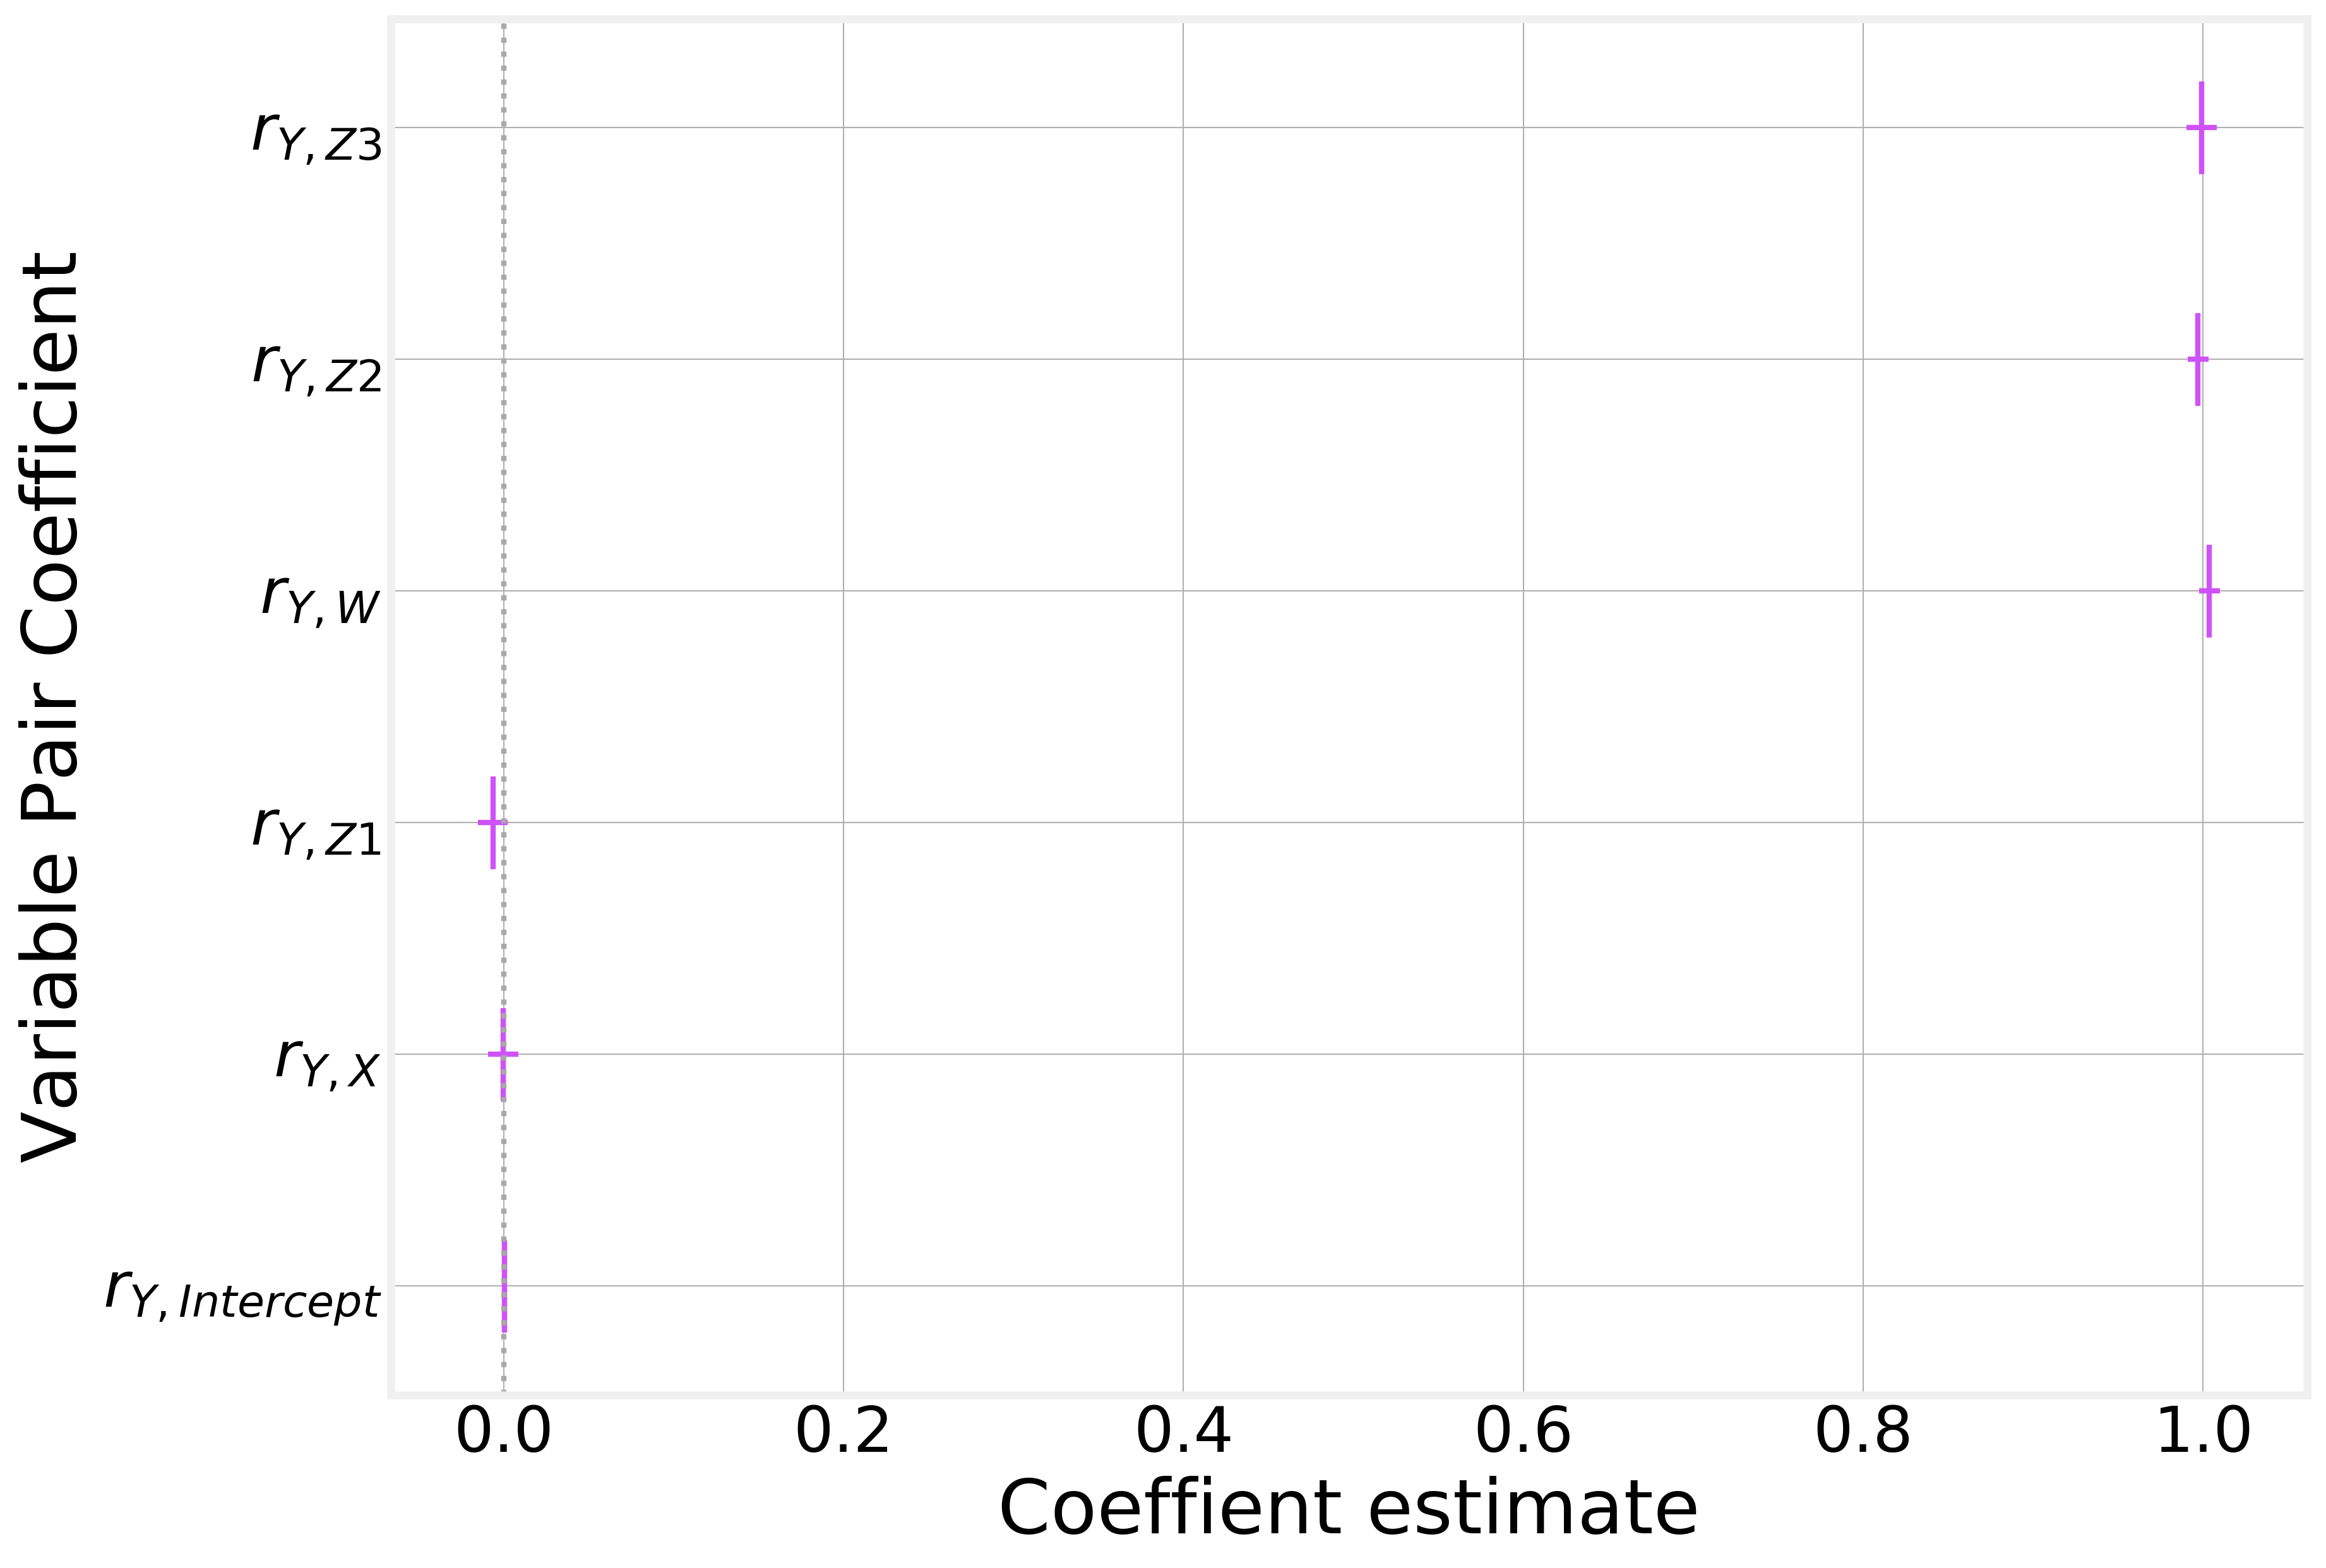

In [26]:
plot_coefficients(results)

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>